<a href="https://colab.research.google.com/github/alexandertaoadams/AlexanderAdamsMastersThesis/blob/main/NB_Chinatown_Sparse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Classification: Chinatown

**URL to original dataset:**  
https://www.timeseriesclassification.com/description.php?Dataset=Chinatown


This notebook trains a **sparse variational Gaussian Process** on the Chinatown dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install gpjax
!pip install sktime

In [ ]:
# jax libraries
import numpy as np
import jax
import jax.numpy as jnp

# gpjax libraries
import gpjax as gpx

# core libraries
from flax import nnx
import optax as ox

# data manipulation and visualisation libraries
import pandas as pd
from sktime.datasets import load_from_tsfile
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
!git clone https://github.com/alexandertaoadams/AlexanderAdamsMastersThesis.git

import sys
sys.path.insert(0, '/content/AlexanderAdamsMastersThesis')
import AlexanderAdamsMastersThesis.src as src

from src.kernels import SignatureKernel
from src.inducing_variables import initial_inducing_variables
from src.utils import display_parameters, display_results, normalise

from src.models import CollapsedBernoulliVariationalGaussian
from src.objectives import collapsed_elbo_bernoulli

### **Data Loading and Preprocessing**

In [5]:
file_path_train = "/content/drive/MyDrive/DATA_Chinatown/Chinatown_TRAIN.ts"
file_path_test = "/content/drive/MyDrive/DATA_Chinatown/Chinatown_TEST.ts"

train_data, train_labels = load_from_tsfile(file_path_train)
test_data, test_labels = load_from_tsfile(file_path_test)

In [6]:
train_data_2 = jnp.array((np.stack([np.stack(row) for row in train_data.to_numpy()])))
train_labels_2 = jnp.array([int(i)-1 for i in train_labels])
xtrain, train_mean, train_std = normalise(train_data_2)
ytrain = train_labels_2
print(xtrain.shape)
print(ytrain.shape)
print(ytrain)

(20, 1, 24)
(20,)
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


In [7]:
test_data_2 = jnp.array((np.stack([np.stack(row) for row in test_data.to_numpy()])))
test_labels_2 = jnp.array([int(i)-1 for i in test_labels])
xtest = (test_data_2 - train_mean) / (train_std)
ytest = test_labels_2
print(xtest.shape)
print(ytest.shape)
print(ytest)

(343, 1, 24)
(343,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1]


### **Model Training**



In [ ]:
# Initialising model
q_kernel = SignatureKernel(xtrain.shape[1], xtrain.shape[2], 4)
q_mean_function = gpx.mean_functions.Constant(constant=jnp.array([0.5]))
q_prior = gpx.gps.Prior(mean_function=q_mean_function, kernel=q_kernel)
q_likelihood = gpx.likelihoods.Bernoulli(xtrain.shape[0])
q_posterior = q_likelihood * q_prior

# Create dataset, initialise inducing variables
D = gpx.dataset.Dataset(jnp.reshape(xtrain, (xtrain.shape[0], -1)), jnp.expand_dims(ytrain, axis=1))
Z = initial_inducing_variables(xtrain, ytrain, 8)

# Model
q_collapsed = CollapsedBernoulliVariationalGaussian(
    posterior=q_posterior,
    inducing_inputs=Z
)

In [ ]:
# Training
collapsed_optimised_model, history = gpx.fit(
    model=q_collapsed,
    objective= lambda model, data: -collapsed_elbo_bernoulli(model, data),
    train_data=D,
    optim=ox.adam(learning_rate=1e-4),
    trainable=gpx.parameters.Parameter,
    num_iters=2000,
    batch_size=20,
    verbose=True
)

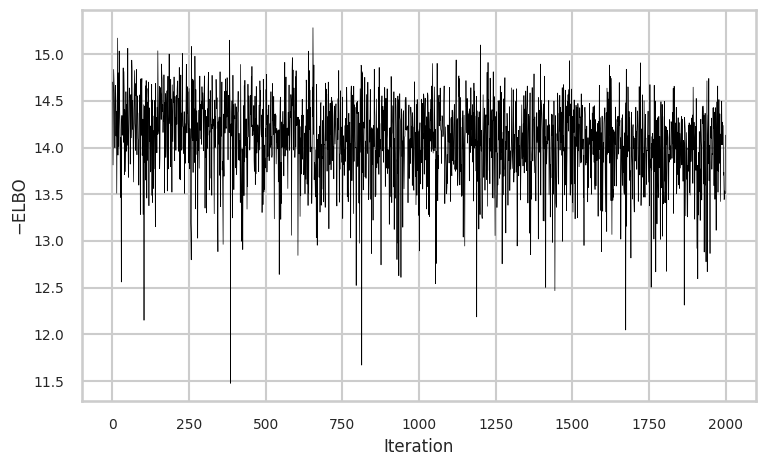

In [10]:
# Plot training process
sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(8, 5))
plt.plot(history, color="black", linewidth=0.5, label="Training ELBO")
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("−ELBO", fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
plt.show()

In [11]:
# Display model hyperparameters
params = display_parameters(collapsed_optimised_model)
params

,Parameter,Count,Values
0,Lengthscales,1,[1.2903914]
1,Amplitude,1,[1.0833104]
2,Weights,5,"[0.9968215, 1.1077971, 0.94358575, 1.060498, 1..."


### **Model Evaluation**

In [12]:
# Get predicted means
latent_dist = collapsed_optimised_model.predict(xtest, D)
predicted_dist = collapsed_optimised_model.posterior.likelihood(latent_dist)
predicted_mean_collapsed = predicted_dist.mean

# Get predicted class labels (round to nearest int)
predicted_labels_collapsed = jnp.round(predicted_mean_collapsed)

# print("Predicted means:", predicted_mean_collapsed)
# print("Predicted labels:", predicted_labels_collapsed)
# print("True labels:", ytest)


In [13]:
# Display results
results = display_results(predicted_labels_collapsed, ytest)
results

,Value
Metric,
Test Size,343.000
Negative Samples,94.000
Postive Samples,249.000
MCC,0.720
F1 score,0.928
Precision,0.905
Recall,0.952
